<a href="https://colab.research.google.com/github/vera-ogake/Tomato_disease_Prediction/blob/main/New_Crop_disease_detection_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow
!pip install imagehash
!pip install opencv-python-headless

In [3]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [5]:
from PIL import Image
import os
import cv2
import imagehash
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from tqdm import tqdm
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import hashlib
from PIL import Image, UnidentifiedImageError
import random

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
input_dir = "/content/drive/MyDrive/Final_project/Sample_data"
output_dir = "/content/drive/MyDrive/Final_project/Output_dir"

In [11]:
# Renaming the files names based on their folder names
def rename_folder_files_name(base_path):
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)

        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)

                if os.path.isfile(file_path):
                    file_ext = os.path.splitext(filename)[-1]

                    unique_id = str(uuid.uuid4())[:4]

                    new_filename = f"{folder}_{unique_id}{file_ext}"
                    new_filepath = os.path.join(folder_path, new_filename)

                    os.rename(file_path, new_filename)
                    print(f"Rename: {filename} -> {new_filename}")

# base_dir = "/content/drive/MyDrive/Final_project/Output_dir"
# rename_folder_files_name((base_dir))

In [12]:
import shutil
import uuid


def sample_images(base_path, output_path, sample_size=5000):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    all_images = [os.path.join(base_path, f) for f in os.listdir(base_path) if os.path.isfile(os.path.join(base_path, f))]

    if len(all_images) == 0:
        print("No images found in the given directory.")
        return

    # Shuffle and select a sample
    random.shuffle(all_images)
    sample_images = all_images[:min(sample_size, len(all_images))]  # Avoid out-of-range errors

    # Copy selected images to new folder
    for img in sample_images:
        shutil.copy(img, output_path)

    print(f"Sampled {len(sample_images)} images to {output_path}")

#sample_images(input_dir, output_dir)

## 1. Resizing Images
Resize all images to a consistent resolution (e.g., 224x224 or 256x256) to ensure uniformity in input size for the CNN.

In [13]:
def resize_images(input_folder, output_folder, target_size=(224, 224)):
    """
    Resizes all images in the input directory to the target size using OpenCV.

    Args:
        input_folder (str): Path to the directory containing input images.
        output_folder (str): Path to the directory to save resized images.
        target_size (tuple): Target size (width, height) for resizing. Default is (224, 224).
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Loop through all files in the input directory
    for filename in os.listdir(input_folder):
        # Check if the file is an image (case-insensitive)
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)

            # Check if the image was read successfully
            if image is None:
                print(f"Warning: Could not read image {filename}. Skipping.")
                continue

            # Resize the image
            resized_image = cv2.resize(image, target_size)

            # Save the resized image
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, resized_image)

    print(f"Resizing complete! Resized images saved in {output_folder}")

In [14]:
resize_images(input_dir, output_dir, target_size=(224, 224))

Resizing complete! Resized images saved in /content/drive/MyDrive/Final_project/Output_dir


## 2. Normalization
Normalize pixel values to a range of [0, 1] or [-1, 1] by dividing by 255 or using mean and standard deviation normalization.

In [15]:
def normalize_images_opencv(input_dir, output_dir, normalize_range="0_1"):
    """
    Normalizes all images in the input directory using OpenCV.

    Args:
        input_dir (str): Path to the directory containing resized images.
        output_dir (str): Path to the directory to save normalized images.
        normalize_range (str): Normalization range. Options: "0_1" (default) or "-1_1".
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
      os.makedirs(output_dir)

    # Loop through all images in the input directory
    for filename in os.listdir(input_dir):
        # Check if the file is an image (case-insensitive)
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path)

            # Check if the image was read successfully
            if image is None:
                print(f"Warning: Could not read image {filename}. Skipping.")
                continue

            # Normalize the image
            if normalize_range == "0_1":
                normalized_image = image / 255.0  # Normalize to [0, 1]
            elif normalize_range == "-1_1":
                normalized_image = (image / 127.5) - 1  # Normalize to [-1, 1]
            else:
                raise ValueError("Invalid normalize_range. Use '0_1' or '-1_1'.")

            # Convert back to uint8 for saving
            normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)

            # Save the normalized image
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, normalized_image_uint8)

    print(f"Normalization complete! Normalized images saved in {output_dir}")

In [16]:
normalize_images_opencv(input_dir, output_dir, normalize_range="0_1")

Normalization complete! Normalized images saved in /content/drive/MyDrive/Final_project/Output_dir


## 3. Grayscale Conversion
Convert RGB images to grayscale if color information is not critical for disease detection

In [17]:
def convert_to_grayscale_opencv(input_dir, output_dir):
    """
    Converts all RGB images in the input directory to grayscale using OpenCV.

    Args:
        input_dir (str): Path to the directory containing input images.
        output_dir (str): Path to the directory to save grayscale images.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Loop through all images in the input directory
    for filename in os.listdir(input_dir):
        # Check if the file is an image (case-insensitive)
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path)

            # Check if the image was read successfully
            if image is None:
                print(f"Warning: Could not read image {filename}. Skipping.")
                continue

            # Convert the image to grayscale
            grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Save the grayscale image
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, grayscale_image)

    print(f"Grayscale conversion complete! Grayscale images saved in {output_dir}")

In [18]:
convert_to_grayscale_opencv(input_dir, output_dir)

Grayscale conversion complete! Grayscale images saved in /content/drive/MyDrive/Final_project/Output_dir


In [19]:
# image of the Tomata display
def display_sample_images(base_path, num_images=10):
  """
  Displays a specified number of random images from the given directory.

  Args:
      base_path (str): Path to the directory containing images.
      num_images (int): Number of images to display. Default is 10.
  """

  # This line creates a list called all_images containing the full paths to all files within the base_path directory that are actual files (not subdirectories).
  all_images = [os.path.join(base_path, f) for f in os.listdir(base_path) if os.path.isfile(os.path.join(base_path, f))]

  if len(all_images) == 0:
      print("No images found in the given directory.")
      return

  # Select 10 random images
  sample_images = random.sample(all_images, min(num_images, len(all_images)))

  # Display images
  fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Create a grid for displaying images
  axes = axes.ravel()  # Flatten the 2D grid into a 1D array

  for i, img_path in enumerate(sample_images):
      img = cv2.imread(img_path)  # Read the image
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display
      axes[i].imshow(img)  # Show image
      axes[i].set_title(os.path.basename(img_path))  # Set title as filename
      axes[i].axis("off")  # Hide axes

  plt.tight_layout()
  plt.show()

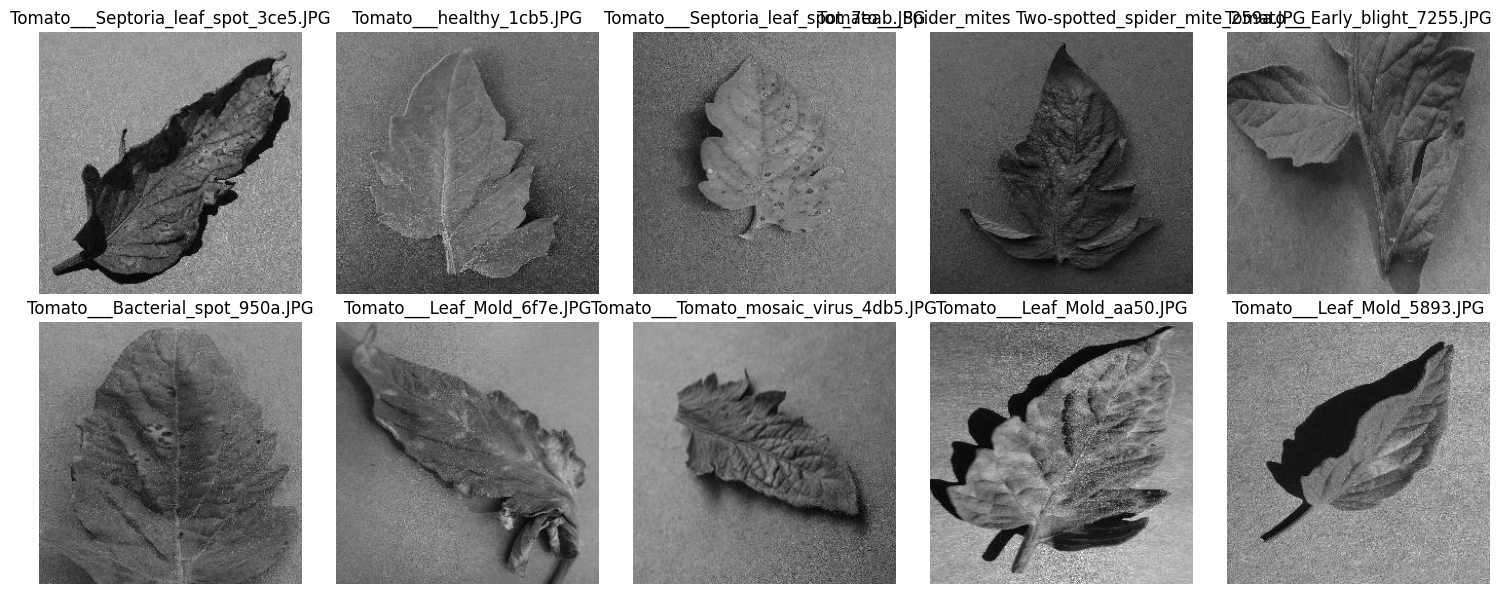

In [20]:
display_sample_images(output_dir)

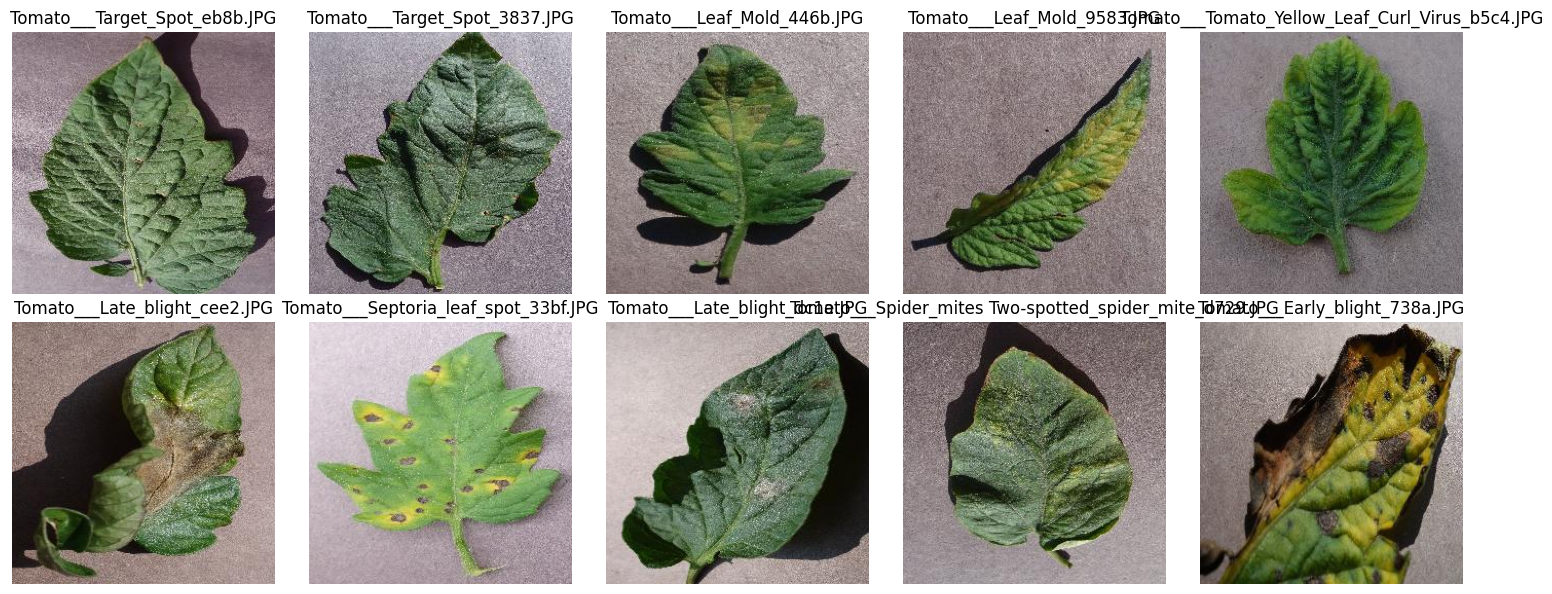

In [21]:
display_sample_images(input_dir)

## 4. Color Space Transformation
Convert images to alternative color spaces like HSV, LAB, or YCrCb to enhance specific features like disease spots or discoloration.

In [22]:
def convert_color_space_opencv(input_dir, output_dir, color_space="HSV"):
    """
    Converts all images in the input directory to the specified color space using OpenCV.

    Args:
        input_dir (str): Path to the directory containing input images.
        output_dir (str): Path to the directory to save converted images.
        color_space (str): Target color space. Options: "HSV", "LAB", or "YCrCb". Default is "HSV".
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Define the color space conversion flag
    if color_space == "HSV":
        conversion_flag = cv2.COLOR_BGR2HSV
    elif color_space == "LAB":
        conversion_flag = cv2.COLOR_BGR2LAB
    elif color_space == "YCrCb":
        conversion_flag = cv2.COLOR_BGR2YCrCb
    else:
        raise ValueError("Invalid color space. Use 'HSV', 'LAB', or 'YCrCb'.")

    # Loop through all images in the input directory
    for filename in os.listdir(input_dir):
        # Check if the file is an image (case-insensitive)
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path)

            # Check if the image was read successfully
            if image is None:
                print(f"Warning: Could not read image {filename}. Skipping.")
                continue

            # Convert the image to the specified color space
            converted_image = cv2.cvtColor(image, conversion_flag)

            # Save the converted image
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, converted_image)

    print(f"Color space conversion complete! Converted images saved in {output_dir}")

In [23]:
convert_color_space_opencv(input_dir, output_dir, color_space="HSV")

Color space conversion complete! Converted images saved in /content/drive/MyDrive/Final_project/Output_dir


## 5. Noise Reduction
Apply filters like Gaussian blur, median blur, or bilateral filtering to reduce noise and smooth the image.

In [24]:
def reduce_noise_opencv(input_dir, output_dir, filter_type="gaussian", kernel_size=5):
    """
    Applies noise reduction filters to all images in the input directory using OpenCV.

    Args:
        input_dir (str): Path to the directory containing input images.
        output_dir (str): Path to the directory to save denoised images.
        filter_type (str): Type of filter to apply. Options: "gaussian", "median", or "bilateral". Default is "gaussian".
        kernel_size (int): Size of the kernel for filtering. Must be an odd integer. Default is 5.
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Validate kernel size (must be odd)
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be an odd integer.")

    # Loop through all images in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Check for image files
            # Read the image
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path)

            # Apply the specified filter
            if filter_type == "gaussian":
                denoised_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
            elif filter_type == "median":
                denoised_image = cv2.medianBlur(image, kernel_size)
            elif filter_type == "bilateral":
                denoised_image = cv2.bilateralFilter(image, kernel_size, 75, 75)
            else:
                raise ValueError("Invalid filter type. Use 'gaussian', 'median', or 'bilateral'.")

            # Save the denoised image
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, denoised_image)

    print(f"Noise reduction complete! Denoised images saved in {output_dir}")

In [25]:
reduce_noise_opencv(input_dir, output_dir, filter_type="gaussian", kernel_size=5)

Noise reduction complete! Denoised images saved in /content/drive/MyDrive/Final_project/Output_dir


## 6. Contrast Enhancement
Use techniques like histogram equalization or adaptive histogram equalization (CLAHE) to improve contrast and highlight disease symptoms.

In [26]:
def enhance_contrast_opencv(input_dir, output_dir, method="histogram_equalization", clip_limit=2.0, grid_size=(8, 8)):
    """
    Enhances the contrast of all images in the input directory using OpenCV.

    Args:
        input_dir (str): Path to the directory containing input images.
        output_dir (str): Path to the directory to save contrast-enhanced images.
        method (str): Contrast enhancement method. Options: "histogram_equalization" or "clahe". Default is "histogram_equalization".
        clip_limit (float): Threshold for contrast limiting (used only for CLAHE). Default is 2.0.
        grid_size (tuple): Size of the grid for CLAHE (used only for CLAHE). Default is (8, 8).
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Loop through all images in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Check for image files
            # Read the image
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path)

            # Convert the image to grayscale (required for histogram equalization and CLAHE)
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Apply the specified contrast enhancement method
            if method == "histogram_equalization":
                enhanced_image = cv2.equalizeHist(gray_image)
            elif method == "clahe":
                clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
                enhanced_image = clahe.apply(gray_image)
            else:
                raise ValueError("Invalid method. Use 'histogram_equalization' or 'clahe'.")

            # Save the enhanced image
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, enhanced_image)

    print(f"Contrast enhancement complete! Enhanced images saved in {output_dir}")

In [27]:
enhance_contrast_opencv(input_dir, output_dir, method="clahe", clip_limit=2.0, grid_size=(8, 8))

Contrast enhancement complete! Enhanced images saved in /content/drive/MyDrive/Final_project/Output_dir


## 7. Background Removal
Segment the crop from the background using techniques like thresholding, edge detection, or semantic segmentation.

In [28]:
def remove_background_opencv(input_dir, output_dir, method="thresholding"):
    """
    Removes the background from all images in the input directory using OpenCV.

    Args:
        input_dir (str): Path to the directory containing input images.
        output_dir (str): Path to the directory to save images with background removed.
        method (str): Background removal method. Options: "thresholding" or "edge_detection". Default is "thresholding".
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Loop through all images in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Check for image files
            # Read the image
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path)

            # Convert the image to grayscale
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Apply the specified background removal method
            if method == "thresholding":
                # Apply binary thresholding
                _, mask = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY_INV)
            elif method == "edge_detection":
                # Detect edges using Canny edge detection
                edges = cv2.Canny(gray_image, 100, 200)
                # Dilate edges to create a mask
                kernel = np.ones((5, 5), np.uint8)
                mask = cv2.dilate(edges, kernel, iterations=1)
            else:
                raise ValueError("Invalid method. Use 'thresholding' or 'edge_detection'.")

            # Invert the mask (optional, depending on the method)
            mask = cv2.bitwise_not(mask)

            # Apply the mask to the original image
            result = cv2.bitwise_and(image, image, mask=mask)

            # Save the result
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, result)

    print(f"Background removal complete! Images saved in {output_dir}")

In [29]:
remove_background_opencv(input_dir, output_dir, method="thresholding")

Background removal complete! Images saved in /content/drive/MyDrive/Final_project/Output_dir


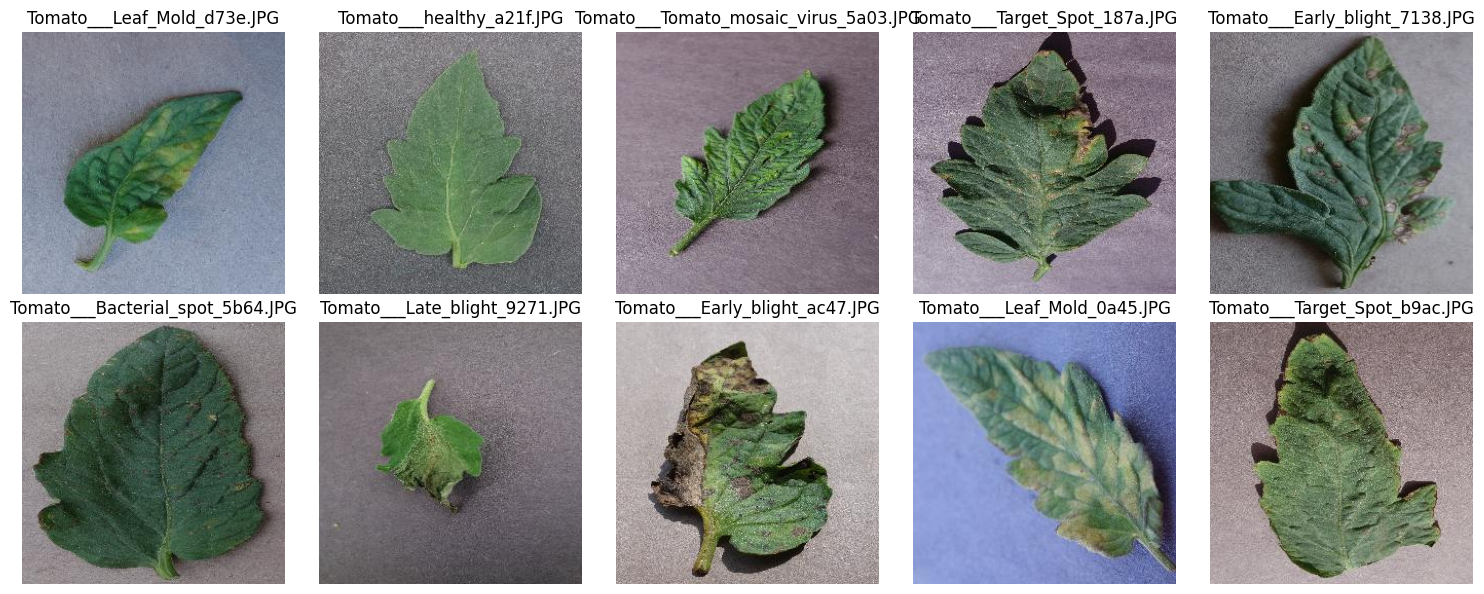

In [ ]:
display_sample_images(output_dir)

## 8. Image Augmentation
Apply transformations like rotation, flipping, zooming, and cropping to increase dataset diversity and reduce overfitting.

In [30]:
def augment_images_opencv(input_dir, output_dir, augmentations=["rotation", "flipping", "zooming", "cropping"], num_augmentations=3):
    """
    Applies image augmentations to all images in the input directory using OpenCV.

    Args:
        input_dir (str): Path to the directory containing input images.
        output_dir (str): Path to the directory to save augmented images.
        augmentations (list): List of augmentations to apply. Options: "rotation", "flipping", "zooming", "cropping". Default is all.
        num_augmentations (int): Number of augmented images to generate per input image. Default is 3.
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Loop through all images in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Check for image files
            # Read the image
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path)

            # Generate augmented images
            for i in range(num_augmentations):
                augmented_image = image.copy()

                # Apply random augmentations
                if "rotation" in augmentations:
                    angle = random.uniform(-30, 30)  # Random rotation angle between -30 and 30 degrees
                    h, w = augmented_image.shape[:2]
                    rotation_matrix = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
                    augmented_image = cv2.warpAffine(augmented_image, rotation_matrix, (w, h))

                if "flipping" in augmentations:
                    flip_code = random.choice([-1, 0, 1])  # Randomly choose flip direction
                    augmented_image = cv2.flip(augmented_image, flip_code)

                if "zooming" in augmentations:
                    zoom_factor = random.uniform(0.8, 1.2)  # Random zoom factor between 0.8x and 1.2x
                    h, w = augmented_image.shape[:2]
                    new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)
                    augmented_image = cv2.resize(augmented_image, (new_w, new_h))
                    if zoom_factor < 1:  # Pad if zoomed out
                        pad_h = h - new_h
                        pad_w = w - new_w
                        augmented_image = cv2.copyMakeBorder(augmented_image, pad_h // 2, pad_h - pad_h // 2,
                                                              pad_w // 2, pad_w - pad_w // 2, cv2.BORDER_CONSTANT, value=[0, 0, 0])
                    else:  # Crop if zoomed in
                        start_h = (new_h - h) // 2
                        start_w = (new_w - w) // 2
                        augmented_image = augmented_image[start_h:start_h + h, start_w:start_w + w]

                if "cropping" in augmentations:
                    h, w = augmented_image.shape[:2]
                    crop_size = random.randint(int(0.8 * h), int(0.95 * h))  # Random crop size
                    start_h = random.randint(0, h - crop_size)
                    start_w = random.randint(0, w - crop_size)
                    augmented_image = augmented_image[start_h:start_h + crop_size, start_w:start_w + crop_size]
                    augmented_image = cv2.resize(augmented_image, (w, h))  # Resize back to original dimensions

                # Save the augmented image
                output_filename = f"{os.path.splitext(filename)[0]}_aug_{i}{os.path.splitext(filename)[1]}"
                output_path = os.path.join(output_dir, output_filename)
                cv2.imwrite(output_path, augmented_image)

    print(f"Image augmentation complete! Augmented images saved in {output_dir}")

In [31]:
augment_images_opencv(input_dir, output_dir, augmentations=["rotation", "flipping", "zooming", "cropping"], num_augmentations=3)

Image augmentation complete! Augmented images saved in /content/drive/MyDrive/Final_project/Output_dir


## 9. White Balancing
Correct color imbalances caused by lighting conditions using white balancing techniques.

In [32]:
def white_balance_images_opencv(input_dir, output_dir, method="gray_world"):
    """
    Applies white balancing to all images in the input directory using OpenCV.

    Args:
        input_dir (str): Path to the directory containing input images.
        output_dir (str): Path to the directory to save white-balanced images.
        method (str): White balancing method. Options: "gray_world". Default is "gray_world".
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Loop through all images in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Check for image files
            # Read the image
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path)

            # Apply the specified white balancing method
            if method == "gray_world":
                # Convert the image to float32 for calculations
                image = image.astype(np.float32)

                # Calculate the average intensity for each channel
                avg_b = np.mean(image[:, :, 0])
                avg_g = np.mean(image[:, :, 1])
                avg_r = np.mean(image[:, :, 2])

                # Calculate the scaling factors for each channel
                scale_b = (avg_b + avg_g + avg_r) / (3 * avg_b)
                scale_g = (avg_b + avg_g + avg_r) / (3 * avg_g)
                scale_r = (avg_b + avg_g + avg_r) / (3 * avg_r)

                # Apply the scaling factors to each channel
                image[:, :, 0] = np.clip(image[:, :, 0] * scale_b, 0, 255)
                image[:, :, 1] = np.clip(image[:, :, 1] * scale_g, 0, 255)
                image[:, :, 2] = np.clip(image[:, :, 2] * scale_r, 0, 255)

                # Convert back to uint8
                balanced_image = image.astype(np.uint8)
            else:
                raise ValueError("Invalid method. Use 'gray_world'.")

            # Save the white-balanced image
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, balanced_image)

    print(f"White balancing complete! White-balanced images saved in {output_dir}")

In [33]:
white_balance_images_opencv(input_dir, output_dir, method="gray_world")

White balancing complete! White-balanced images saved in /content/drive/MyDrive/Final_project/Output_dir


## 10. Image Sharpening
Enhance edges and details using sharpening filters like unsharp masking or Laplacian filters.

In [34]:
def sharpen_images_opencv(input_dir, output_dir, method="unsharp_masking", kernel_size=(5, 5), strength=1.5):
    """
    Sharpens all images in the input directory using OpenCV.

    Args:
        input_dir (str): Path to the directory containing input images.
        output_dir (str): Path to the directory to save sharpened images.
        method (str): Sharpening method. Options: "unsharp_masking" or "laplacian". Default is "unsharp_masking".
        kernel_size (tuple): Size of the kernel for blurring (used only for unsharp masking). Default is (5, 5).
        strength (float): Strength of the sharpening effect. Default is 1.5.
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Loop through all images in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Check for image files
            # Read the image
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path)

            # Apply the specified sharpening method
            if method == "unsharp_masking":
                # Apply Gaussian blur to the image
                blurred = cv2.GaussianBlur(image, kernel_size, 0)
                # Subtract the blurred image from the original to create a mask
                mask = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
                # Clip the pixel values to the valid range [0, 255]
                sharpened_image = np.clip(mask, 0, 255).astype(np.uint8)
            elif method == "laplacian":
                # Apply the Laplacian filter
                laplacian = cv2.Laplacian(image, cv2.CV_64F)
                # Add the Laplacian result to the original image
                sharpened_image = np.clip(image + strength * laplacian, 0, 255).astype(np.uint8)
            else:
                raise ValueError("Invalid method. Use 'unsharp_masking' or 'laplacian'.")

            # Save the sharpened image
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, sharpened_image)

    print(f"Image sharpening complete! Sharpened images saved in {output_dir}")

In [35]:
sharpen_images_opencv(input_dir, output_dir, method="unsharp_masking", kernel_size=(5, 5), strength=1.5)

Image sharpening complete! Sharpened images saved in /content/drive/MyDrive/Final_project/Output_dir


## 11. Removal of Artifacts
Manually or automatically remove artifacts like dust, watermarks, or shadows that may interfere with disease detection.

In [36]:
def remove_artifacts_opencv(input_dir, output_dir, artifact_mask_dir=None, use_inpainting=True):
    """
    Removes artifacts from all images in the input directory using OpenCV.

    Args:
        input_dir (str): Path to the directory containing input images.
        output_dir (str): Path to the directory to save cleaned images.
        artifact_mask_dir (str): Path to the directory containing artifact masks (optional). If not provided, a simple mask will be generated.
        use_inpainting (bool): Whether to use inpainting for artifact removal. Default is True.
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Loop through all images in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Check for image files
            # Read the image
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path)

            # Generate or load the artifact mask
            if artifact_mask_dir:
                # Load the mask from the provided directory
                mask_path = os.path.join(artifact_mask_dir, filename)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            else:
                # Generate a simple mask (e.g., for dust or small artifacts)
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                _, mask = cv2.threshold(gray_image, 250, 255, cv2.THRESH_BINARY)  # Detect bright artifacts

            # Remove artifacts using inpainting
            if use_inpainting:
                cleaned_image = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
            else:
                # Alternative: Replace artifact regions with the median color of the image
                median_color = np.median(image, axis=(0, 1))
                cleaned_image = image.copy()
                cleaned_image[mask == 255] = median_color

            # Save the cleaned image
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, cleaned_image)

    print(f"Artifact removal complete! Cleaned images saved in {output_dir}")

In [38]:
remove_artifacts_opencv(input_dir, output_dir, use_inpainting=True)

Artifact removal complete! Cleaned images saved in /content/drive/MyDrive/Final_project/Output_dir


## 12. Image Cropping
Crop images to focus only on the diseased regions of the crop, removing irrelevant parts of the image.

In [39]:
def crop_images_opencv(input_dir, output_dir, roi_coords=None, use_auto_detection=True):
    """
    Crops images to focus on diseased regions using OpenCV.

    Args:
        input_dir (str): Path to the directory containing input images.
        output_dir (str): Path to the directory to save cropped images.
        roi_coords (dict): Dictionary mapping filenames to ROI coordinates (x, y, w, h). If None, auto-detection is used.
        use_auto_detection (bool): Whether to automatically detect diseased regions. Default is True.
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Loop through all images in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Check for image files
            # Read the image
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path)

            # Get the region of interest (ROI)
            if roi_coords and filename in roi_coords:
                # Use predefined ROI coordinates
                x, y, w, h = roi_coords[filename]
            elif use_auto_detection:
                # Automatically detect diseased regions (e.g., using thresholding)
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                _, binary_mask = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY_INV)

                # Find contours of the diseased regions
                contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # Get the bounding box of the largest contour
                if contours:
                    largest_contour = max(contours, key=cv2.contourArea)
                    x, y, w, h = cv2.boundingRect(largest_contour)
                else:
                    # If no contours are found, use the entire image
                    x, y, w, h = 0, 0, image.shape[1], image.shape[0]
            else:
                # If no ROI is provided and auto-detection is disabled, use the entire image
                x, y, w, h = 0, 0, image.shape[1], image.shape[0]

            # Crop the image
            cropped_image = image[y:y + h, x:x + w]

            # Save the cropped image
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, cropped_image)

    print(f"Cropping complete! Cropped images saved in {output_dir}")

In [41]:
# roi_coords = {
#     "image1.jpg": (50, 50, 200, 200),
#     "image2.png": (100, 100, 150, 150),
# }
#roi_coords=roi_coords,
crop_images_opencv(input_dir, output_dir, use_auto_detection=True)

Cropping complete! Cropped images saved in /content/drive/MyDrive/Final_project/Output_dir


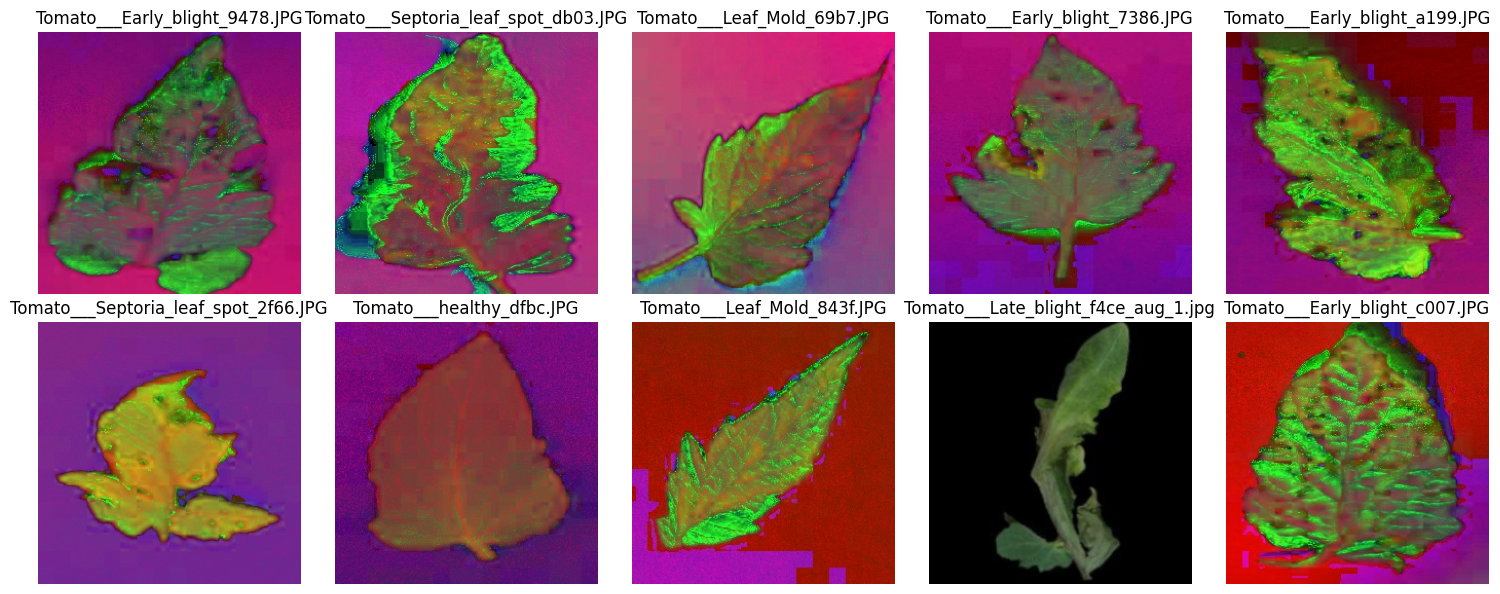

In [42]:
display_sample_images(output_dir)

## 13. Remove Duplicate Images
Duplicate images can skew your dataset and lead to overfitting. We can use hashing to identify and remove duplicates

In [43]:
def calculate_image_hash(image_path):
    """
    Calculates the hash of an image file.
    Args:
        image_path (str): Path to the image file.
    Returns:
        str: MD5 hash of the image.
    """
    with open(image_path, 'rb') as f:
        image_hash = hashlib.md5(f.read()).hexdigest()
    return image_hash

def remove_duplicate_images(input_dir):
    """
    Removes duplicate images from the dataset.
    Args:
        input_dir (str): Path to the directory containing images.
    """
    # Dictionary to store image hashes and paths
    hash_dict = {}

    # Loop through all images in the directory
    for root, _, files in os.walk(input_dir):
        for filename in files:
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_path = os.path.join(root, filename)
                image_hash = calculate_image_hash(image_path)

                # Check if the hash already exists
                if image_hash in hash_dict:
                    print(f"Removing duplicate: {image_path}")
                    os.remove(image_path)
                else:
                    hash_dict[image_hash] = image_path

In [44]:
remove_duplicate_images(input_dir)

## 14. Remove Empty Files
Empty files can cause errors during data loading. This function checks for files with zero size and removes them.

In [45]:
def remove_empty_files(input_dir):
    """
    Removes empty files from the dataset.
    Args:
        input_dir (str): Path to the directory containing files.
    """
    # Loop through all files in the directory
    for root, _, files in os.walk(input_dir):
        for filename in files:
            file_path = os.path.join(root, filename)
            if os.path.getsize(file_path) == 0:  # Check if file is empty
                print(f"Removing empty file: {file_path}")
                os.remove(file_path)


remove_empty_files(input_dir)

## 15. Histogram Matching
Standardize the brightness and contrast of images by matching their histograms to a reference image

In [48]:
def histogram_matching_opencv(input_dir, output_dir, reference_image_path):
    """
    Matches the histograms of all images in the input directory to a reference image using OpenCV.

    Args:
        input_dir (str): Path to the directory containing input images.
        output_dir (str): Path to the directory to save histogram-matched images.
        reference_image_path (str): Path to the reference image for histogram matching.
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Load the reference image
    reference_image = cv2.imread(reference_image_path, cv2.IMREAD_COLOR)
    if reference_image is None:
        raise ValueError("Reference image not found or could not be loaded.")

    # Convert the reference image to LAB color space
    reference_image_lab = cv2.cvtColor(reference_image, cv2.COLOR_BGR2LAB)

    # Compute the histogram of the reference image (for the L channel)
    reference_hist, _ = np.histogram(reference_image_lab[:, :, 0], bins=256, range=(0, 256))

    # Compute the cumulative distribution function (CDF) of the reference histogram
    reference_cdf = reference_hist.cumsum()
    reference_cdf = (reference_cdf - reference_cdf.min()) * 255 / (reference_cdf.max() - reference_cdf.min())
    reference_cdf = reference_cdf.astype(np.uint8)

    # Loop through all images in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Check for image files
            # Read the image
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path)

            # Convert the image to LAB color space
            image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

            # Compute the histogram of the input image (for the L channel)
            image_hist, _ = np.histogram(image_lab[:, :, 0], bins=256, range=(0, 256))

            # Compute the cumulative distribution function (CDF) of the input histogram
            image_cdf = image_hist.cumsum()
            image_cdf = (image_cdf - image_cdf.min()) * 255 / (image_cdf.max() - image_cdf.min())
            image_cdf = image_cdf.astype(np.uint8)

            # Perform histogram matching
            matched_l_channel = np.interp(image_lab[:, :, 0].flatten(), image_cdf, reference_cdf).reshape(image_lab[:, :, 0].shape)

            # Update the L channel in the LAB image
            image_lab[:, :, 0] = matched_l_channel

            # Convert the image back to BGR color space
            matched_image = cv2.cvtColor(image_lab, cv2.COLOR_LAB2BGR)

            # Save the histogram-matched image
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, matched_image)

    print(f"Histogram matching complete! Matched images saved in {output_dir}")

In [49]:
reference_image_path = "/content/drive/MyDrive/Final_project/Output_dir/Tomato___Bacterial_spot_00b9.JPG"  # Path to the reference image
histogram_matching_opencv(input_dir, output_dir, reference_image_path)

Histogram matching complete! Matched images saved in /content/drive/MyDrive/Final_project/Output_dir


## 16. Image Denoising
Use advanced denoising techniques like Non-Local Means (NLM) or wavelet transforms to remove noise while preserving edges.

In [50]:
import pywt

def denoise_images_opencv(input_dir, output_dir, method="nlm", strength=10):
    """
    Denoises all images in the input directory using advanced techniques like Non-Local Means (NLM) or wavelet transforms.

    Args:
        input_dir (str): Path to the directory containing input images.
        output_dir (str): Path to the directory to save denoised images.
        method (str): Denoising method. Options: "nlm" (Non-Local Means) or "wavelet". Default is "nlm".
        strength (float): Denoising strength (used only for NLM). Default is 10.
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Loop through all images in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Check for image files
            # Read the image
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path)

            # Apply the specified denoising method
            if method == "nlm":
                # Non-Local Means Denoising
                denoised_image = cv2.fastNlMeansDenoisingColored(image, None, strength, strength, 7, 21)
            elif method == "wavelet":
                # Wavelet Transform Denoising
                # Convert the image to grayscale
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                # Perform wavelet transform
                coeffs = pywt.dwt2(gray_image, 'haar')
                cA, (cH, cV, cD) = coeffs
                # Threshold the detail coefficients (cH, cV, cD)
                threshold = np.std(cD) / 2  # Adjust threshold as needed
                cH = pywt.threshold(cH, threshold, mode='soft')
                cV = pywt.threshold(cV, threshold, mode='soft')
                cD = pywt.threshold(cD, threshold, mode='soft')
                # Reconstruct the image
                coeffs_denoised = cA, (cH, cV, cD)
                denoised_gray_image = pywt.idwt2(coeffs_denoised, 'haar')
                # Convert back to uint8
                denoised_gray_image = np.uint8(np.clip(denoised_gray_image, 0, 255))
                # Convert grayscale image back to BGR
                denoised_image = cv2.cvtColor(denoised_gray_image, cv2.COLOR_GRAY2BGR)
            else:
                raise ValueError("Invalid method. Use 'nlm' or 'wavelet'.")

            # Save the denoised image
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, denoised_image)

    print(f"Denoising complete! Denoised images saved in {output_dir}")

In [51]:
denoise_images_opencv(input_dir, output_dir, method="nlm", strength=10)

Denoising complete! Denoised images saved in /content/drive/MyDrive/Final_project/Output_dir


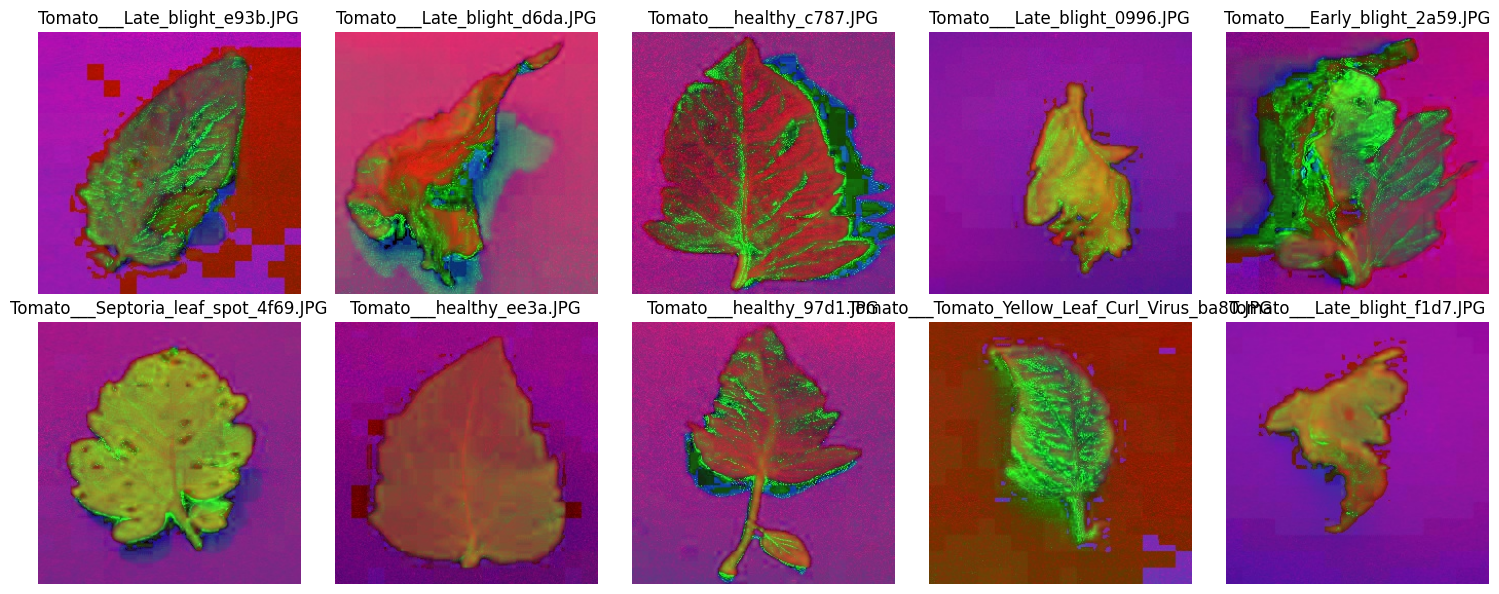

In [52]:
display_sample_images(output_dir)

## 16. Data Balancing
Ensure the dataset is balanced by oversampling minority classes or undersampling majority classes to avoid bias in the CNN model.

In [53]:
import random
import shutil
from collections import defaultdict

def balance_dataset(input_dir, output_dir, mode="oversample", label_separator="_"):
    """
    Balances the dataset by oversampling minority classes or undersampling majority classes.
    Saves all balanced images in a single output folder.

    Args:
        input_dir (str): Path to the directory containing images.
        output_dir (str): Path to the directory to save balanced images.
        mode (str): Balancing mode. Options: "oversample" (default) or "undersample".
        label_separator (str): Separator used to extract class labels from filenames. Default is "_".
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Group images by class
    class_images = defaultdict(list)
    for filename in os.listdir(input_dir):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            # Extract class label from filename (assumes format: classname_image.jpg)
            class_label = filename.split(label_separator)[0]
            class_images[class_label].append(filename)

    # Debug: Print class counts
    print("Class counts:", {k: len(v) for k, v in class_images.items()})

    # Determine the target number of images per class
    if mode == "oversample":
        if not class_images:
            raise ValueError("No valid images or classes found in the input directory.")
        target_count = max(len(images) for images in class_images.values())  # Oversample to match the majority class
    elif mode == "undersample":
        if not class_images:
            raise ValueError("No valid images or classes found in the input directory.")
        target_count = min(len(images) for images in class_images.values())  # Undersample to match the minority class
    else:
        raise ValueError("Invalid mode. Use 'oversample' or 'undersample'.")

    # Balance the dataset
    for class_label, images in class_images.items():
        if mode == "oversample":
            # Oversample by duplicating random images
            for i in range(target_count):
                image = random.choice(images)
                src_path = os.path.join(input_dir, image)
                dst_path = os.path.join(output_dir, f"{class_label}_{i}_{image}")
                shutil.copy(src_path, dst_path)
        elif mode == "undersample":
            # Undersample by randomly selecting images
            selected_images = random.sample(images, target_count)
            for image in selected_images:
                src_path = os.path.join(input_dir, image)
                dst_path = os.path.join(output_dir, image)
                shutil.copy(src_path, dst_path)

    print(f"Dataset balancing complete! Balanced dataset saved in {output_dir}")

In [54]:
balance_dataset(input_dir, output_dir, mode="oversample", label_separator="_")

Class counts: {'Tomato': 1209}
Dataset balancing complete! Balanced dataset saved in /content/drive/MyDrive/Final_project/Output_dir


## EXPLORATORY DATA ANALYSIS

## 1. Class Distribution Analysis
Purpose: Understand the distribution of images across different disease classes.

Implementation:

Count the number of images in each class folder.

Plot a bar chart or pie chart to visualize the distribution.

Insights: Identify class imbalance, which may require data balancing techniques.

In [58]:
def plot_class_distribution(input_dir):
    class_folders = [f for f in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, f))]
    class_counts = {class_folder: len(os.listdir(os.path.join(input_dir, class_folder))) for class_folder in class_folders}

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()

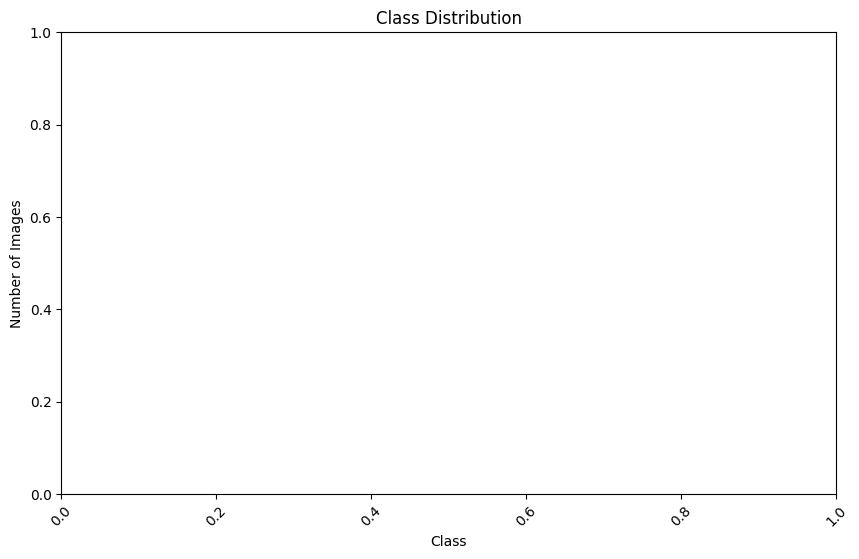

In [59]:
plot_class_distribution(output_dir)

## 2. Image Size Analysis
Purpose: Check the dimensions of images in the dataset.

Implementation:

Load a few images and print their shapes.

Plot a histogram of image widths and heights.

Insights: Identify if resizing is necessary for consistency.

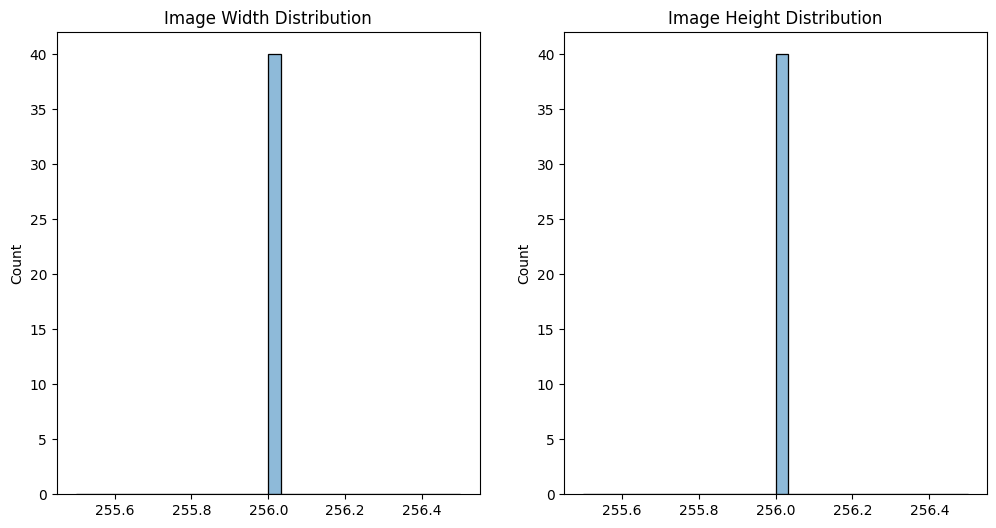

In [60]:
def analyze_image_sizes(input_dir):
    image_sizes = []
    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path)
            image_sizes.append(image.shape[:2])  # (height, width)

    widths = [size[1] for size in image_sizes]
    heights = [size[0] for size in image_sizes]

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(widths, bins=30, kde=True)
    plt.title("Image Width Distribution")

    plt.subplot(1, 2, 2)
    sns.histplot(heights, bins=30, kde=True)
    plt.title("Image Height Distribution")
    plt.show()

analyze_image_sizes(output_dir)

## 3. Color Distribution Analysis
Purpose: Analyze the color distribution of images.

Implementation:

Plot histograms of pixel intensity values for each channel (R, G, B).

Insights: Identify color biases or anomalies.

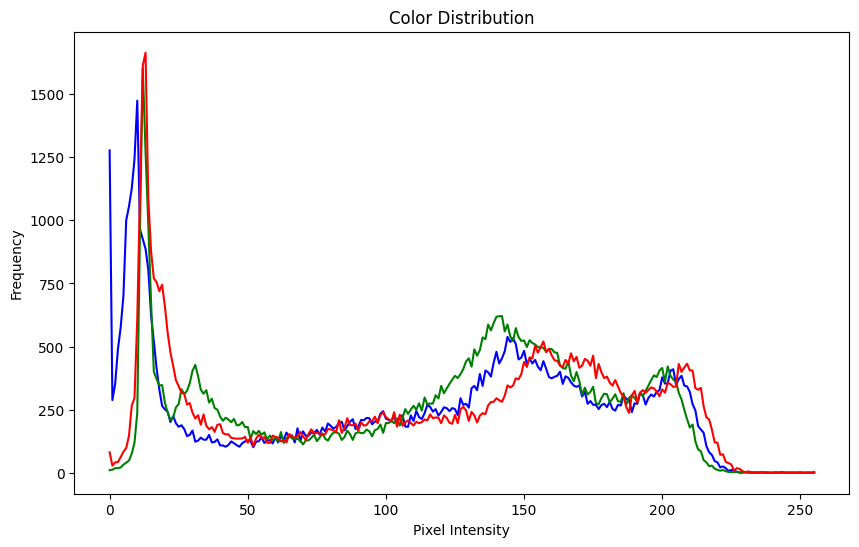

In [62]:
def plot_color_distribution(image):
    colors = ('b', 'g', 'r')
    plt.figure(figsize=(10, 6))
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
    plt.title("Color Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

image_path = "/content/drive/MyDrive/Final_project/Output_dir/Tomato_1001_Tomato___Early_blight_d7e8.JPG"
image = cv2.imread(image_path)
plot_color_distribution(image)

## 4. Image Quality Analysis
Purpose: Check for blurry or low-quality images.

Implementation:

Compute the Laplacian variance for each image (a measure of sharpness).

Plot a histogram of Laplacian variances.

Insights: Identify images that may need preprocessing (e.g., sharpening).

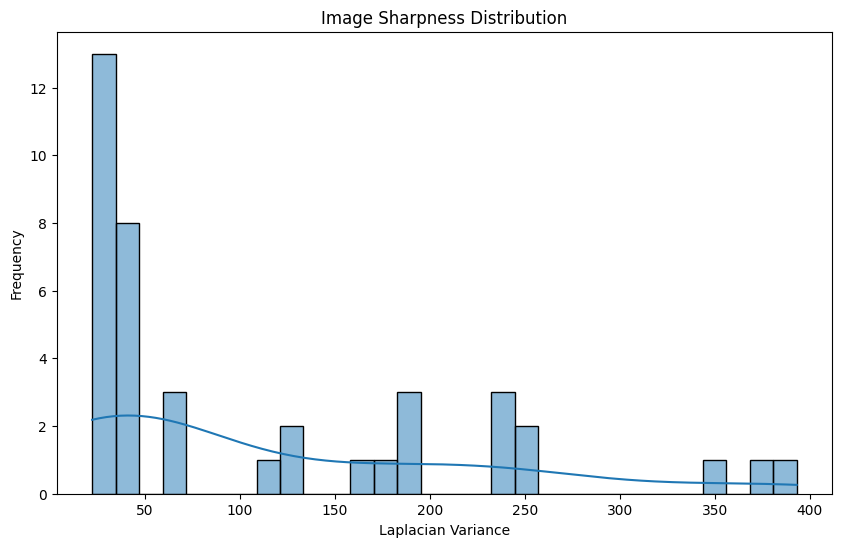

In [63]:
def analyze_image_quality(input_dir):
    variances = []
    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            variance = cv2.Laplacian(image, cv2.CV_64F).var()
            variances.append(variance)

    plt.figure(figsize=(10, 6))
    sns.histplot(variances, bins=30, kde=True)
    plt.title("Image Sharpness Distribution")
    plt.xlabel("Laplacian Variance")
    plt.ylabel("Frequency")
    plt.show()


analyze_image_quality(output_dir)

## 5. Disease Spot Analysis
Purpose: Analyze the size and location of disease spots.

Implementation:

Use thresholding or edge detection to identify disease spots.

Plot the distribution of spot sizes and locations.

Insights: Understand the characteristics of disease symptoms.

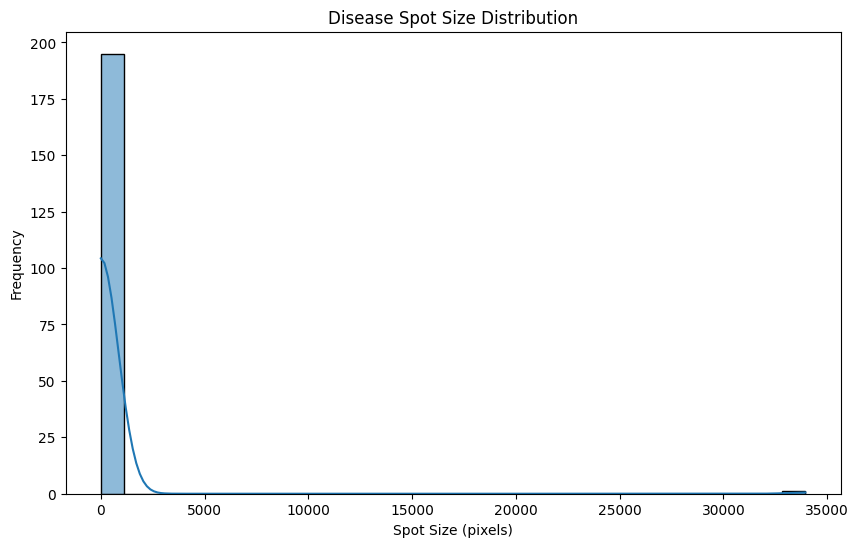

In [65]:
def analyze_disease_spots(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    spot_sizes = [cv2.contourArea(contour) for contour in contours]
    plt.figure(figsize=(10, 6))
    sns.histplot(spot_sizes, bins=30, kde=True)
    plt.title("Disease Spot Size Distribution")
    plt.xlabel("Spot Size (pixels)")
    plt.ylabel("Frequency")
    plt.show()


image_path = "/content/drive/MyDrive/Final_project/Output_dir/Tomato_1001_Tomato___Early_blight_d7e8.JPG"
image = cv2.imread(image_path)
analyze_disease_spots(image)

## 6. Noise Analysis
Purpose: Analyze the noise level in images.

Implementation:

Compute the standard deviation of pixel intensities for each image.

Plot a histogram of noise levels.

Insights: Identify images that may need denoising.

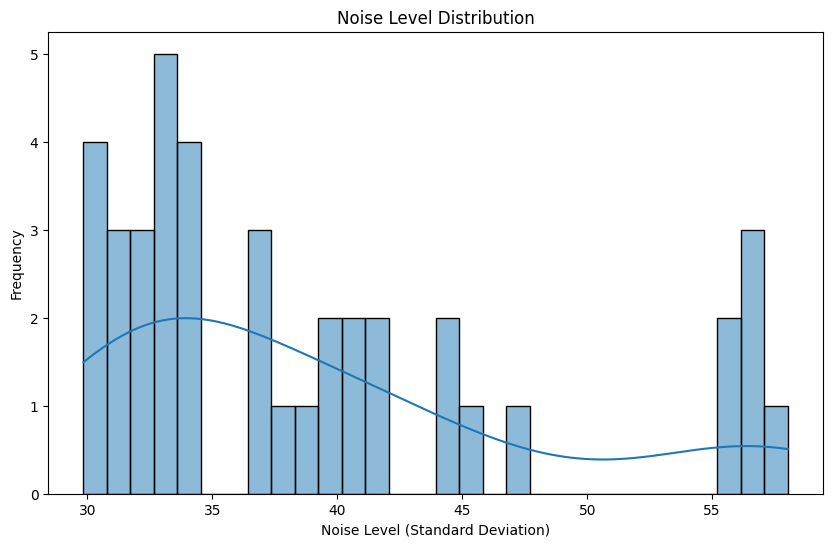

In [66]:
def analyze_noise_levels(input_dir):
    noise_levels = []
    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            noise_levels.append(np.std(image))

    plt.figure(figsize=(10, 6))
    sns.histplot(noise_levels, bins=30, kde=True)
    plt.title("Noise Level Distribution")
    plt.xlabel("Noise Level (Standard Deviation)")
    plt.ylabel("Frequency")
    plt.show()

analyze_noise_levels(output_dir)

## 7. Augmentation Effect Analysis
Purpose: Visualize the effects of augmentation techniques.

Implementation:

Apply augmentations (e.g., rotation, flipping) to a sample image.

Display the original and augmented images side by side.

Insights: Ensure augmentations are applied correctly.

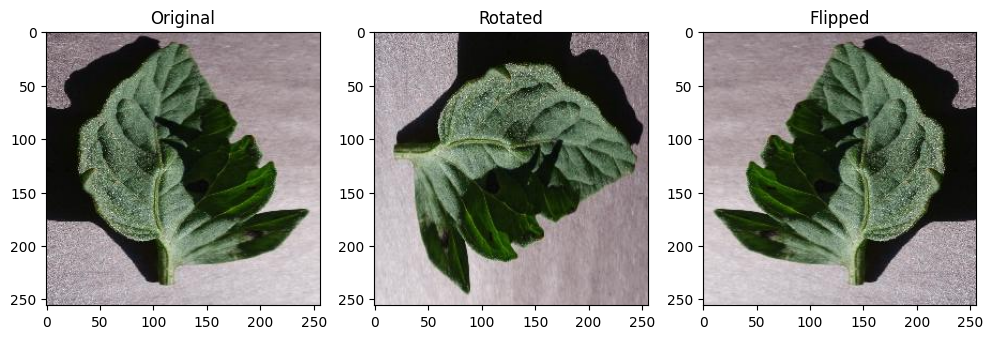

In [68]:
def visualize_augmentations(image):
    # Apply augmentations
    rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    flipped = cv2.flip(image, 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original")

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
    plt.title("Rotated")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(flipped, cv2.COLOR_BGR2RGB))
    plt.title("Flipped")
    plt.show()

image_path = "/content/drive/MyDrive/Final_project/Output_dir/Tomato_1001_Tomato___Early_blight_d7e8.JPG"
image = cv2.imread(image_path)
visualize_augmentations(image)

## 8. Background Analysis
Purpose: Analyze the background of images.

Implementation:

Use thresholding to separate the background from the foreground.

Plot the distribution of background colors.

Insights: Identify if background removal is necessary.

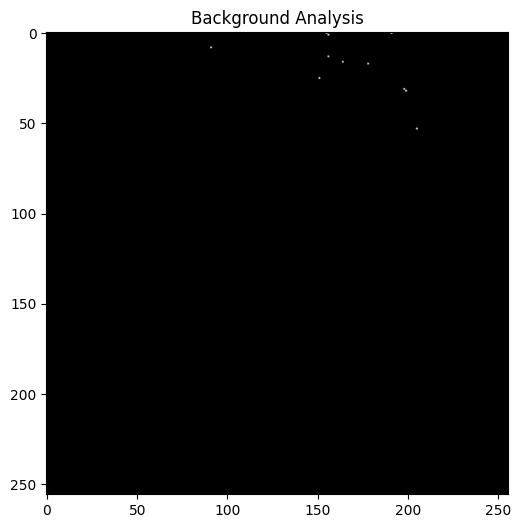

In [72]:
def analyze_background(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)
    background = cv2.bitwise_and(image, image, mask=binary_mask)

    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
    plt.title("Background Analysis")
    plt.show()

image_path = "/content/drive/MyDrive/Final_project/Output_dir/Tomato_0_Tomato___Tomato_mosaic_virus_7741.JPG"
image = cv2.imread(image_path)
analyze_background(image)

## 9. Correlation Analysis
Purpose: Analyze correlations between image features and disease classes.

Implementation:

Extract features (e.g., mean intensity, texture) and compute correlations with disease classes.

Plot a heatmap of correlations.

Insights: Identify important features for disease detection.

In [ ]:
from skimage.feature import graycomatrix, graycoprops

# Function to calculate image features
def calculate_image_features(image_path):
    """
    Calculates image features including mean intensity, contrast, correlation, energy, and homogeneity.

    Args:
        image_path (str): Path to the image file.

    Returns:
        dict: A dictionary containing the calculated image features.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    features = {}

    # Mean Intensity
    features['mean_intensity'] = np.mean(image)

    # Calculate GLCM properties
    distances = [1]  # Distance between pixels
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Angles
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    # Contrast, Correlation, Energy, Homogeneity
    # Update: Accessing properties correctly
    features['contrast'] = graycoprops(glcm, 'contrast')[0][0]
    features['correlation'] = graycoprops(glcm, 'correlation')[0][0]
    features['energy'] = graycoprops(glcm, 'energy')[0][0]
    features['homogeneity'] = graycoprops(glcm, 'homogeneity')[0][0]

    return features

def analyze_correlations(input_dir):
    """
    Analyzes correlations between image features and disease classes.
    Args:
        input_dir (str): Path to the directory containing class folders.
    """
    # Initialize a list to store feature data
    feature_data = []

    # Loop through each class folder
    class_folders = [f for f in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, f))]
    for class_folder in class_folders:
        class_path = os.path.join(input_dir, class_folder)
        images = [f for f in os.listdir(class_path) if f.endswith(".jpg") or f.endswith(".png")]

        # Extract features for each image in the class
        for image_name in images:
            image_path = os.path.join(class_path, image_name)
            features = calculate_image_features(image_path)  # Pass image_path here
            features['class'] = class_folder
            feature_data.append(features)

    # Convert feature data to a DataFrame
    df = pd.DataFrame(feature_data)

    # Select only numerical features for correlation analysis
    numerical_features = ['mean_intensity', 'contrast', 'correlation', 'energy', 'homogeneity']

    # Compute correlation matrix for numerical features
    correlation_matrix = df[numerical_features].corr()

    # Plot the correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Between Features and Classes")
    plt.show()

analyze_correlations(input_dir)

## 10. Dataset Visualization
Purpose: Visualize a sample of images from each class.

Implementation:

Display a grid of images from each class.

Insights: Get a quick overview of the dataset.

In [86]:
def visualize_dataset(input_dir, num_samples=5):
    class_folders = [f for f in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, f))]
    plt.figure(figsize=(15, 10))
    for i, class_folder in enumerate(class_folders):
        class_path = os.path.join(input_dir, class_folder)
        images = [f for f in os.listdir(class_path) if f.endswith(".jpg") or f.endswith(".png")]
        for j in range(num_samples):
            image_path = os.path.join(class_path, images[j])
            image = cv2.imread(image_path)
            plt.subplot(len(class_folders), num_samples, i * num_samples + j + 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title(class_folder)
            plt.axis("off")
    plt.show()

visualize_dataset(output_dir)

<Figure size 1500x1000 with 0 Axes>

# MODE TRAINING

In [87]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Extract unique class labels (without extension and UUID)
class_labels = set()
for filename in os.listdir(output_dir):
    if filename.endswith(('.jpg', '.JPG', '.png', '.PNG')):
        filename_without_ext = os.path.splitext(filename)[0]
        class_name = "_".join(filename_without_ext.split("_")[:-1])
        class_labels.add(class_name)


In [88]:
# Sort the class labels for consistency
class_labels = sorted(list(class_labels))
label_to_index = {label: idx for idx, label in enumerate(class_labels)}
print("Class labels:", class_labels)

Class labels: ['Tomato_0_Tomato___Tomato_mosaic_virus', 'Tomato_1000_Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato_1001_Tomato___Early_blight', 'Tomato_1002_Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_1003_Tomato___Septoria_leaf_spot', 'Tomato_1004_Tomato___Septoria_leaf_spot', 'Tomato_1005_Tomato___Target_Spot', 'Tomato_1006_Tomato___healthy', 'Tomato_1007_Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_1008_Tomato___Leaf_Mold', 'Tomato_1009_Tomato___healthy', 'Tomato_100_Tomato___Late_blight', 'Tomato_1010_Tomato___Target_Spot', 'Tomato_1011_Tomato___healthy', 'Tomato_1012_Tomato___Target_Spot', 'Tomato_1013_Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_1014_Tomato___Early_blight', 'Tomato_1015_Tomato___Septoria_leaf_spot', 'Tomato_1016_Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato_1017_Tomato___Leaf_Mold', 'Tomato_1018_Tomato___Septoria_leaf_spot', 'Tomato_1019_Tomato___Leaf_Mold', 'Tomato_101_Tomato___Leaf_Mold', 'Tomato_1020_Tomato___Leaf_Mold', 'Tomat

In [89]:
# Load dataset
image_paths = [os.path.join(output_dir, fname) for fname in os.listdir(output_dir) if fname.endswith(('.jpg', '.JPG', '.png', '.PNG'))]
labels = ["_".join(os.path.splitext(os.path.basename(path))[0].split("_")[:-1]) for path in image_paths]
numeric_labels = [label_to_index[label] for label in labels]

In [90]:
# Check for classes with only one sample
from collections import Counter
label_counts = Counter(numeric_labels)
single_sample_classes = [label for label, count in label_counts.items() if count == 1]

# Remove images and labels of single-sample classes
if single_sample_classes:
    print(f"Warning: Removing classes with only one sample: {single_sample_classes}")
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        [path for path, label in zip(image_paths, numeric_labels) if label not in single_sample_classes],
        [label for label in numeric_labels if label not in single_sample_classes],
        test_size=0.2,
        stratify=[label for label in numeric_labels if label not in single_sample_classes]
    )
else:
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        image_paths, numeric_labels, test_size=0.2, stratify=numeric_labels
    )

In [91]:
# Data generator function
def image_generator(image_paths, labels, batch_size=32, img_size=(224, 224)):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]

            images = [img_to_array(load_img(path, target_size=img_size)) / 255.0 for path in batch_paths]
            labels_one_hot = tf.keras.utils.to_categorical(batch_labels, num_classes=len(class_labels))

            yield np.array(images), np.array(labels_one_hot)

In [92]:
# Create data generators
train_generator = image_generator(train_paths, train_labels)
val_generator = image_generator(val_paths, val_labels)

In [93]:
# Define improved CNN model
def create_model(input_shape, num_classes):
    # Import BatchNormalization explicitly here
    from tensorflow.keras.layers import BatchNormalization

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [94]:
# Set input shape and number of classes
input_shape = (224, 224, 3)
num_classes = len(class_labels)

# Create model
model = create_model(input_shape, num_classes)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model
epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_paths) // 32,
    validation_data=val_generator,
    validation_steps=len(val_paths) // 32,
    epochs=epochs,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 270ms/step - accuracy: 0.1899 - loss: 4.9691 - val_accuracy: 0.0893 - val_loss: 7.1210 - learning_rate: 1.0000e-04
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 477ms/step - accuracy: 0.6404 - loss: 1.6212 - val_accuracy: 0.0000e+00 - val_loss: 7.2338 - learning_rate: 1.0000e-04
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step - accuracy: 0.7694 - loss: 1.0010 - val_accuracy: 0.0000e+00 - val_loss: 7.2241 - learning_rate: 1.0000e-04
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - accuracy: 0.8071 - loss: 0.6617 - val_accuracy: 0.0279 - val_loss: 7.0369 - learning_rate: 1.0000e-04
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 266ms/step - accuracy: 0.8922 - loss: 0.4320 - val_accuracy: 0.0000e+00 - val_loss: 6.7162 - learning_rate: 1.0000e-04


In [95]:
# Save the model
model.save("/content/drive/MyDrive/Final_project/model/crop_disease_cnn_model.h5")

In [99]:
def evaluate_model(model, test_generator, class_labels):
    """Evaluates the model and displays accuracy, loss, and metrics."""
    loss, accuracy = model.evaluate(test_generator)
    print(f'Test Loss: {loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')

    # Predict on test data
    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator.classes

    # Confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print(classification_report(true_labels, predicted_labels, target_names=class_labels))

In [ ]:
evaluate_model(model, train_generator, class_labels)

In [102]:
def interpret_prediction(predictions, image_path):
    """
    Interprets the model's predictions using the image filename as the class label.

    Args:
        predictions (numpy.ndarray): Predicted probabilities for each class.
        image_path (str): Path to the input image.

    Returns:
        str: Predicted class label (filename without extension).
        float: Confidence score.
    """
    # Get the predicted class index
    predicted_class_index = np.argmax(predictions)

    # Get the predicted class label (filename without extension)
    predicted_class_label = os.path.splitext(os.path.basename(image_path))[0]

    # Get the confidence score
    confidence_score = predictions[0][predicted_class_index]

    return predicted_class_label, confidence_score


# def interpret_prediction(predictions, class_labels):
#     """Interprets model predictions by returning the class with the highest probability."""
#     predicted_label = np.argmax(predictions)
#     confidence = np.max(predictions) * 100
#     return f'Predicted Class: {class_labels[predicted_label]}, Confidence: {confidence:.2f}%'

In [ ]:
predictions = model.predict(val_generator)
interpret_prediction(predictions[0], val_paths[0])

In [106]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(image_path, model):
    """
    Loads an image, preprocesses it, and makes a prediction using the provided model.

    Args:
        image_path (str): Path to the input image.
        model (tensorflow.keras.Model): The trained model to use for prediction.

    Returns:
        numpy.ndarray: Predicted probabilities for each class.
    """
    img = image.load_img(image_path, target_size=(224, 224))  # Load and resize image
    x = image.img_to_array(img)  # Convert image to array
    x = np.expand_dims(x, axis=0)  # Add batch dimension
    x = x / 255.0  # Normalize pixel values

    predictions = model.predict(x)  # Make prediction

    return predictions

# Example usage
image_path = "/content/drive/MyDrive/Final_project/Sample_data/Tomato___Bacterial_spot_00b9.JPG"

# Load the model
model = load_model("/content/drive/MyDrive/Final_project/model/crop_disease_cnn_model.h5")

# Make prediction
predictions = predict_image(image_path, model)

# Interpret the prediction
predicted_class, confidence = interpret_prediction(predictions, image_path)
print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: Tomato___Bacterial_spot_00b9, Confidence: 0.04


## Visualizing Prediction results

In [108]:
def visualize_predictions(model, test_generator, class_labels, num_images=5):
    """Displays sample test images with model predictions and confidence scores."""
    test_images, test_labels = next(test_generator)
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1)

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(test_images[i])
        pred_label = class_labels[predicted_labels[i]]
        actual_label = class_labels[np.argmax(test_labels[i])]
        confidence = confidence_scores[i] * 100
        plt.title(f'Pred: {pred_label}\nActual: {actual_label}\nConf: {confidence:.2f}%', fontsize=10)
        plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step


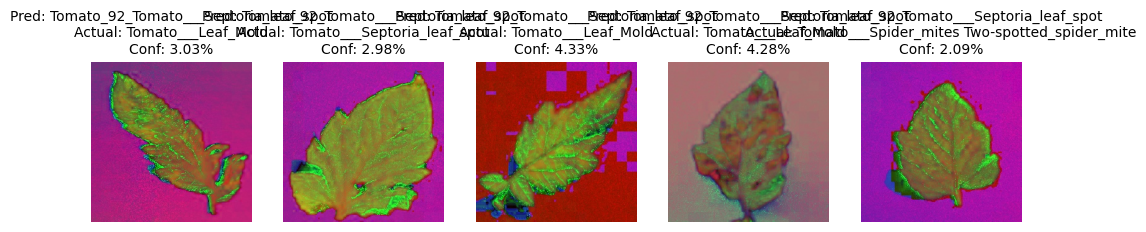

In [109]:
visualize_predictions(model, train_generator,class_labels
                      )